# Model Selection: ARMA

<a href="https://colab.research.google.com/github/febse/ts2025/blob/main/05-ARMA-Fitting-Class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open Class Version In Colab"/>Class Version</a>


In [7]:
# A purely random process with a standard deviation of 1

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# AR(1) parameters
phi_1 = 0.8  # AR coefficient
phi_2 = -0.6
theta_1 = 0.6  # MA coefficient
theta_2 = -0.4
sigma = 1  # standard deviation of noise
n = 100

np.random.seed(42)

noise = arma_generate_sample(ar=[1], ma=[1], nsample=n, scale=sigma)

dt = arma_generate_sample(ar=[1, -phi_1], ma=[1], nsample=n, scale=1.5 * sigma)

dt_ex = pd.read_csv("https://github.com/febse/data/raw/refs/heads/main/ts/ts2025/a1/ts27.csv").squeeze()

## Fitting AR(p) Models

$$
x_t = \phi_0 + \phi_1 x_{t-1} + \phi_2 x_{t-2} + ... + \phi_p x_{t-p} + e_t
$$

where $e_t \sim N(0, \sigma_e^2), E(e_t e_{t-k}) = 0 \text{ for } k \neq 0$.

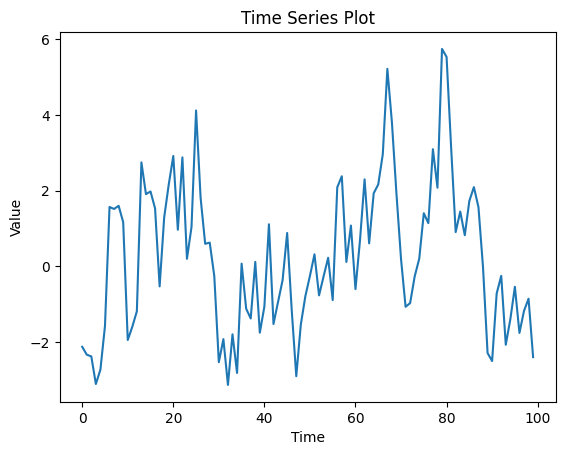

In [8]:
# Plot the series

plt.plot(dt)
plt.title('Time Series Plot')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()


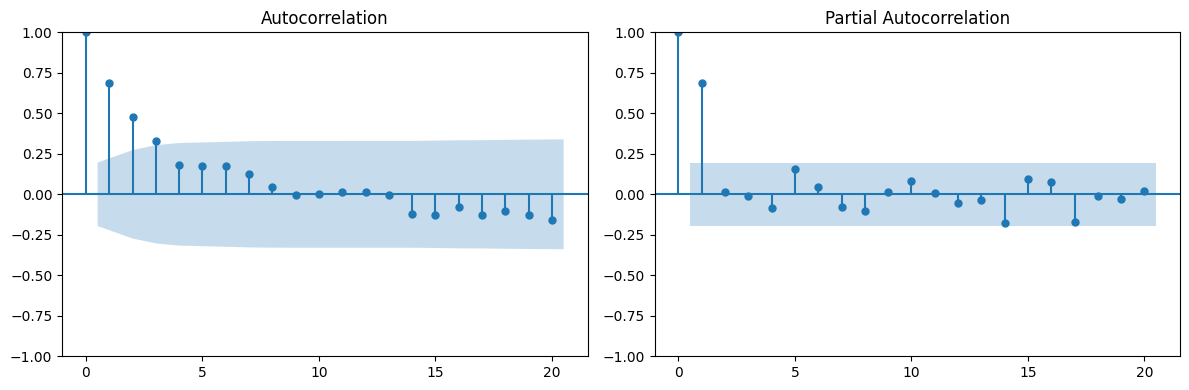

In [9]:
# Plot ACF and PACF

fix, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(dt, ax=ax[0], lags=20)
plot_pacf(dt, ax=ax[1], lags=20)
plt.tight_layout()
plt.show()

In [10]:
# Use statsmodels to fit an AR(1) model and print the summary

import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

model_ar1 = ARIMA(dt, order=(1, 0, 0))
model_ar1_fit = model_ar1.fit()

print(model_ar1_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  100
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -176.074
Date:                Sun, 23 Nov 2025   AIC                            358.148
Time:                        13:39:07   BIC                            365.964
Sample:                             0   HQIC                           361.311
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1497      0.487      0.308      0.758      -0.805       1.104
ar.L1          0.7019      0.084      8.329      0.000       0.537       0.867
sigma2         1.9676      0.285      6.899      0.0

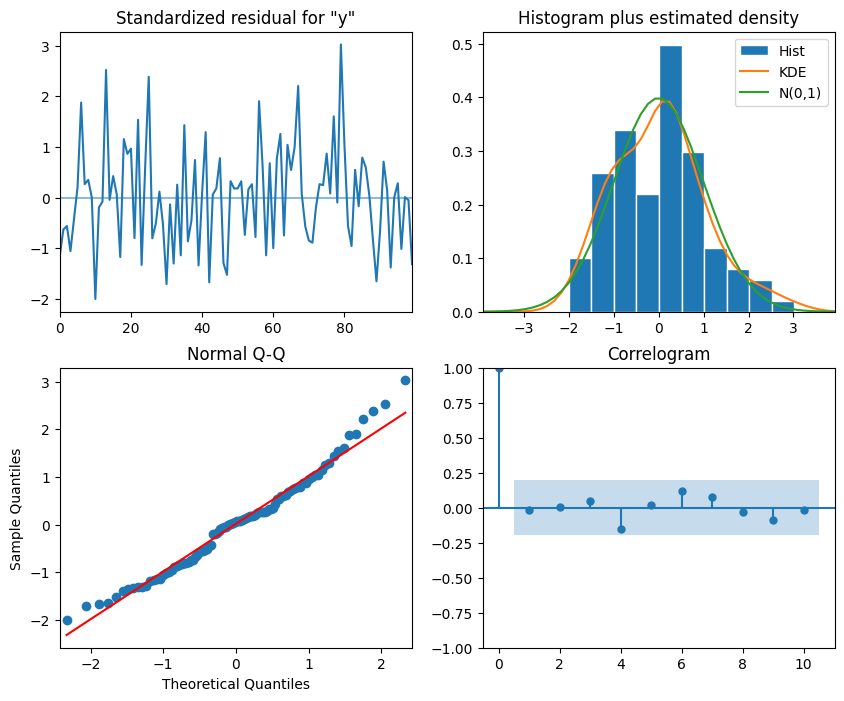

In [11]:
model_ar1_fit.plot_diagnostics(figsize=(10, 8))
plt.show()

## The Jung-Box Test

$$
Q=T(T+2)\sum _{k=1}^{h}{\frac {{\hat {\rho }}_{k}^{2}}{T-k}} \underset{H_0}{\sim} \chi(h)
$$

$$
\begin{align*}
H_0: & \rho_1 = \rho_2 = \ldots = \rho_{h} \\
H_1: & \text{ at least one of } \rho_k \neq 0, \quad k = 1,\ldots, h
\end{align*}
$$

In [12]:
lb_serial_corr = model_ar1_fit.test_serial_correlation("ljungbox")

for i, (stat, p) in enumerate(zip(lb_serial_corr[0][0], lb_serial_corr[0][1])):
    print(f"Lag {i + 1}, test statistic = {stat:.3f} with p-value {p:.3f}")

Lag 1, test statistic = 0.021 with p-value 0.885
Lag 2, test statistic = 0.023 with p-value 0.988
Lag 3, test statistic = 0.256 with p-value 0.968
Lag 4, test statistic = 2.796 with p-value 0.593
Lag 5, test statistic = 2.840 with p-value 0.725
Lag 6, test statistic = 4.369 with p-value 0.627
Lag 7, test statistic = 4.975 with p-value 0.663
Lag 8, test statistic = 5.086 with p-value 0.748
Lag 9, test statistic = 5.900 with p-value 0.750
Lag 10, test statistic = 5.936 with p-value 0.821


In [13]:
forecast = model_ar1_fit.get_forecast(steps=2)

print("Forecasts")
print(forecast.predicted_mean)

print("Standard errors")
print(forecast.se_mean)

Forecasts
[-1.63727143 -1.10451235]
Standard errors
[1.40271028 1.71373084]


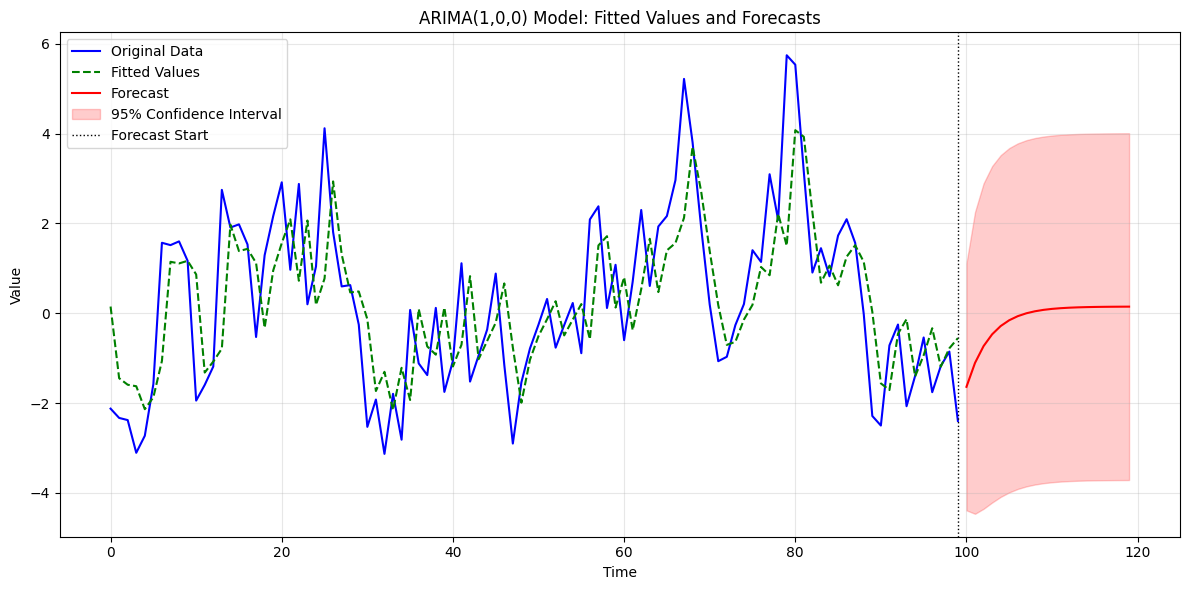

In [14]:
# Plot the prediction of the model

# Get in-sample fitted values
fitted_values = model_ar1_fit.fittedvalues

# Get out-of-sample forecasts (e.g., 20 steps ahead)
forecast_steps = 20
forecast = model_ar1_fit.forecast(steps=forecast_steps)
forecast_index = np.arange(len(dt), len(dt) + forecast_steps)

# Get forecast confidence intervals
forecast_result = model_ar1_fit.get_forecast(steps=forecast_steps)
forecast_ci = np.array(forecast_result.conf_int())  # Convert to numpy array

# Plot
plt.figure(figsize=(12, 6))
plt.plot(dt, label='Original Data', color='blue', linewidth=1.5)
plt.plot(fitted_values, label='Fitted Values', color='green', linewidth=1.5, linestyle='--')
plt.plot(forecast_index, forecast, label='Forecast', color='red', linewidth=1.5)
plt.fill_between(forecast_index, 
                 forecast_ci[:, 0],
                 forecast_ci[:, 1], 
                 color='red', alpha=0.2, label='95% Confidence Interval')
plt.axvline(x=len(dt)-1, color='black', linestyle=':', linewidth=1, label='Forecast Start')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('ARIMA(1,0,0) Model: Fitted Values and Forecasts')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Information Criteria

### Akaike Information Criterion (AIC)

$$
AIC = -2 \underbrace{\log(L)}_{\text{Goodness of fit}} + 2 \underbrace{(p + q + k + 1)}_{\text{number of parameters}}
$$

Information criteria are designed to balance between goodness of fit (how close the model is to the data) and model complexity (how many parameters are in the model). Lower values of AIC indicate a better model.


$$
AICc = AIC + \frac{2(p + q + k + 1)(p + q + k + 2)}{T - p - q - k - 2}
$$

$$
BIC = AIC + (\log(T) - 2)(p + q + k + 1)
$$



## Maximum Likelihood Estimation (MLE)

Although it is outside of the scope for this course, it is worth mentioning that the parameters of ARMA models are typically estimated using Maximum Likelihood Estimation (MLE) or variants thereof (e.g., Conditional MLE). But what is maximum likelihood estimation? This is a rather general method for estimating parameters of a statistical model. Maybe the simplest example is to show it for estimating the probability of success in a binomial distribution.

Let's say that we have an experiment where each outcome is either a success or a failure. We denote the probability of success as $p$ and the probability of failure as $1-p$. If we repeat this experiment $n$ times, the number of successes $k$ follows a binomial distribution:

$$
P(X = k) = \binom{n}{k} p^k (1-p)^{n-k}
$$

Now let's say that we interview 10 persons and ask them whether they support a certain policy. Let's say that 7 out of the 10 persons say "yes". Let the event persons supports the policy be a success. Then we have $n=10$ and $k=7$. Now we can ask the question: What is the value of $p$ that makes the observed data most likely? In other words, what is the value of $p$ that maximizes the probability of observing 7 successes in 10 trials?

Assuming each person answers independently from the others, the likelihood function is given by:

$$
L(p) = P(X = 7) = \binom{10}{7} p^7 (1-p)^{3}
$$

To find the value of $p$ that maximizes this likelihood function, we can take the derivative of $L(p)$ with respect to $p$, set it to zero, and solve for $p$. However, it is often easier to work with the log-likelihood function and minimize the negative log-likelihood instead.

$$
\ell(p) = \log(L(p)) = \log\left(\binom{10}{7}\right) + 7 \log(p) + 3 \log(1-p)
$$

Taking the derivative of the log-likelihood function with respect to $p$ and setting it to zero gives:
$$
\frac{d\ell(p)}{dp} = \frac{7}{p} - \frac{3}{1-p} = 0
$$

Now we can solve for $p$:

$$
p = \frac{7}{10} = 0.7
$$

In other words the ML estimate for the probability of success is simply the observed proportion of successes in the data.

You can quickly check that every other value of $p$ gives a lower likelihood than $p=0.7$.



In [3]:
# Probability of 7 successes in 10 trials for different p

from scipy.stats import binom

prob_7_successes = binom.pmf(7, n=10, p=0.7)
print(f"Probability of exactly 7 successes in 10 trials with p=0.7: {prob_7_successes:.4f}")

prob_7_successes = binom.pmf(7, n=10, p=0.6)
print(f"Probability of exactly 7 successes in 10 trials with p=0.6: {prob_7_successes:.4f}")

prob_7_successes = binom.pmf(7, n=10, p=0.8)
print(f"Probability of exactly 7 successes in 10 trials with p=0.8: {prob_7_successes:.4f}")


Probability of exactly 7 successes in 10 trials with p=0.7: 0.2668
Probability of exactly 7 successes in 10 trials with p=0.6: 0.2150
Probability of exactly 7 successes in 10 trials with p=0.8: 0.2013
